### Import Necessary Package

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
#from scipy.misc import imread
from IPython import display
from PIL import Image
from skimage.transform import rescale
%matplotlib inline

In [3]:
import os
import cv2
from tqdm import tqdm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

### Data Pre-Processing

Get image from the directory.

In [23]:
REBUILD_DATA = True

class EISType():
    
    NS = "Nyquist/Noisy" # Determine the number of type and then give the directory of each type of image
    SH = "Nyquist/SingleHump"
    TH = "Nyquist/TwoHumps"
    TL = "Nyquist/Tail"
    LABELS = {NS:0, SH:1, TH:2, TL:3}
    training_data = []
    nscount = 0
    shcount = 0
    thcount = 0
    tlcount = 0
    
    def make_training_data(self):
        for label in self.LABELS: #iterate the directory
            print(label)
            for f in tqdm(os.listdir(label)): # iterate all the image within the directory, f -> the file name               
                path = os.path.join(label, f) # get the full path to the image
                if "png" in path:                    
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert the iimage to gray scale (optional)
                    img = cv2.resize(img, (800, 536))
                    self.training_data.append([path, np.array(img), np.eye(4)[self.LABELS[label]]])                 

                    if label == self.NS:
                        self.nscount += 1
                    elif label == self.SH:
                        self.shcount += 1
                    elif label == self.TH:
                        self.thcount += 1
                    elif label == self.TL:
                        self.tlcount += 1    

        np.random.shuffle(self.training_data)
        np.save("eis_training_data.npy", self.training_data)
        print("Noisy:", self.nscount)
        print("SingleHump:", self.shcount)
        print("TwoHumps:", self.thcount)
        print("Tail:", self.tlcount)

if REBUILD_DATA:
    Type = EISType()
    Type.make_training_data()
    


Nyquist/Noisy


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:02<00:00, 85.42it/s]


Nyquist/SingleHump


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.18it/s]


Nyquist/TwoHumps


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:02<00:00, 91.31it/s]


Nyquist/Tail


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:02<00:00, 81.65it/s]


Noisy: 198
SingleHump: 199
TwoHumps: 199
Tail: 196


*Load the data to check if all the images have been loaded into the program.*

In [24]:
training_data = np.load("eis_training_data.npy", allow_pickle = True)

In [25]:
print("Size of training_data:", len(training_data))
print("Size of image:", training_data[1][1].shape[1], "x" ,training_data[1][1].shape[0])

Size of training_data: 792
Size of image: 800 x 536


Nyquist/Noisy\200315-1338_sim_spread-True.png


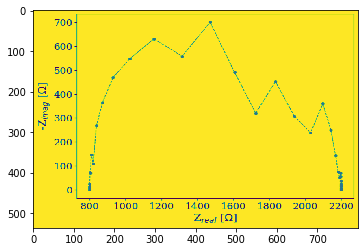

In [69]:
k = 14 #
print(training_data[k][0])
plt.imshow(training_data[k][1])
plt.show()

### CNN Model

In [27]:
class Net(nn.Module):
    
    def __init__(self, input_size, hidden_size, kernel_size, output_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(input_size, hidden_size, kernel_size) 
        self.conv2 = nn.Conv2d(hidden_size, hidden_size*2, kernel_size)
        self.conv3 = nn.Conv2d(hidden_size*2, hidden_size*4, kernel_size)
        self.conv4 = nn.Conv2d(hidden_size*4, hidden_size*8, kernel_size)
        
        self.fc1 = nn.Linear(85376, 64) 
        self.fc2 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))
        
        xF = x.view(-1, 64 * 29 * 46 ) # flatten
        output = F.relu(self.fc1(xF)) # put into the first fully connected layer
        output = self.fc2(output)
        
        return F.softmax(output, dim=1)

<font color='red'>**Try to use sigmoid function rather than hte ReLU at the last linear layer.** </font>

In [28]:
net = Net(1, 8, 5, 4)
print(net)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=85376, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)


### Separate the training data and testing data

In [29]:
X = torch.Tensor([i[1] for i in training_data]).view(-1, 536, 800)
X = X/255.0
y = torch.Tensor([i[2] for i in training_data])

VAL_PCT = 0.2 # 20% for Testing
val_size = int(len(X)*VAL_PCT)
print(val_size)

158


In [30]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print("Training Sample:", len(train_X))
print("Testing Sample:", len(test_X))

Training Sample: 634
Testing Sample: 158


In [31]:
type(train_X)

torch.Tensor

### Import the Optimizing and Loss Function

In [32]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [33]:
BATCH_SIZE = 10
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 536, 800)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(loss)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [03:48<00:00,  3.57s/it]


tensor(0.0003, grad_fn=<MseLossBackward>)


In [110]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 536, 800))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
            
        total += 1
        
print("Accuracy:", round(correct/total,3))

100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [00:59<00:00,  2.65it/s]


Accuracy: 0.924


In [ ]:
for i in range(len(test_X)):
    real_class = torch.argmax(test_y[i])
    net_out = net(test_X[i].view(-1, 1, 134, 336))[0]
    pre = torch.argmax(net_out)
    print(net_out, pre, real_class)

In [113]:
REBUILD_DATA = True

class EISType():
    
    RD = "Nyquist/Random" # Determine the number of type and then give the directory of each type of image
    LABELS = {RD:0}
    random_data = []
    rdcount = 0
        
    def make_random_data(self):
        for label in self.LABELS: #iterate the directory
            print(label)
            for f in tqdm(os.listdir(label)): # iterate all the image within the directory, f -> the file name               
                path = os.path.join(label, f) # get the full path to the image
                fileName = path[15:]
                if "png" in path:
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert the iimage to gray scale (optional)
                    img = cv2.resize(img, (800, 536))
                    self.random_data.append([np.array(img), fileName])

                    if label == self.RD:
                        self.rdcount += 1    
                
        np.random.shuffle(self.random_data)
        np.save("random_data.npy", self.random_data)
        print("Random:", self.rdcount)

if REBUILD_DATA:
    Type = EISType()
    Type.make_random_data()
    


Nyquist/Random


100%|████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 83.85it/s]


Random: 140


In [114]:
random_data = np.load("random_data.npy", allow_pickle = True)

In [115]:
print("Size of random_data:", len(random_data))
print("Size of image:", random_data[1][0].shape[1], "x", random_data[1][0].shape[0])

Size of random_data: 140
Size of image: 800 x 536


200315-0095_sim_one.png


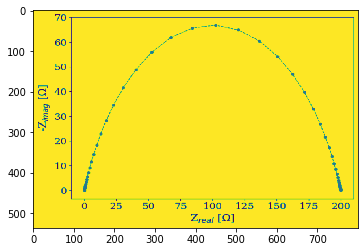

In [116]:
k = 1 #
plt.imshow(random_data[k][0])
print(random_data[k][1])
plt.show()

In [117]:
X = torch.Tensor([i[0] for i in random_data]).view(-1, 536, 800)
X = X/255.0

VAL_PCT = 0.2 # 20% for Testing
val_size = int(len(X)*VAL_PCT)
print(val_size)

28


In [127]:
print(X[1])
print(X[1].shape)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
torch.Size([536, 800])


In [132]:
import termcolor
from termcolor import colored

In [141]:
NScount = 0
SHcount = 0
THcount = 0
TLcount = 0


#for i in tqdm(range(len(X))):
for i in range(len(X)):
    net_out = net(X[i].view(-1, 1, 536, 800))[0]
    predicted_type = torch.argmax(net_out)
    # print(net_out, "->", predicted_type, i)
    if predicted_type == 3:
        TLcount += 1
    elif predicted_type == 1:
        SHcount += 1
    elif predicted_type == 0:
        NScount += 1
        print("Noisy Data ALARM!! File Name:", random_data[i][1])
    elif predicted_type == 2:
        THcount += 1
        
print("Noisy:", NScount)
print("Single Humps:", SHcount)
print("Two Humps:", THcount)
print("Tail:", TLcount)

Noisy Data ALARM!! File Name: 200315-0035_sim_spread-True.png
Noisy Data ALARM!! File Name: 200315-0020_sim_one-True.png
Noisy Data ALARM!! File Name: 200315-0021_sim_spread-True.png
Noisy Data ALARM!! File Name: 200315-0019_sim_spread-True.png
Noisy Data ALARM!! File Name: 200315-0027_sim_spread-True.png
Noisy Data ALARM!! File Name: 200315-0021_sim_one-True.png
Noisy Data ALARM!! File Name: 200315-0036_sim_spread-True.png
Noisy Data ALARM!! File Name: 200315-0032_sim_one-True.png
Noisy Data ALARM!! File Name: 200315-0024_sim_one-True.png
Noisy Data ALARM!! File Name: 200315-0032_sim_spread-True.png
Noisy Data ALARM!! File Name: 200315-0028_sim_one-True.png
Noisy Data ALARM!! File Name: 200315-0025_sim_one-True.png
Noisy Data ALARM!! File Name: 200315-0037_sim_one-True.png
Noisy Data ALARM!! File Name: 200315-0028_sim_spread-True.png
Noisy Data ALARM!! File Name: 200315-0037_sim_spread-True.png
Noisy: 15
Single Humps: 38
Two Humps: 42
Tail: 45
